In [ ]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import config

plt.style.use('seaborn-v0_8')

In [ ]:
result_path = os.path.join(config.RESULTS_PATH, 'syntheticData')

In [ ]:
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from HySpecLab.unmixing import ContrastiveUnmixing
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader

def train(model:nn.Module, n_endmembers:int, dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3, simplex_weight=1e-5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = UnmixingLoss() 
    volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers).to(device)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')
    vol_reg_norm = volume_reg(torch.sigmoid(model.ebk.detach()))
    print(vol_reg_norm)
    


    dataloader = DataLoader(dataset, batch_size=int(len(dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    similarity_weight = 1e-1

    scaler = torch.cuda.amp.GradScaler()

    for epoch in epoch_iterator:
        epoch_loss = 0.
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + simplex_weight*(volume_reg(sigmoid(model.ebk))/vol_reg_norm) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)))

In [ ]:
from scipy import io as sio

synthetic_data_path = "/home/abian/Data/Dataset/HSI/SyntheticData/"
data = sio.loadmat(synthetic_data_path + "Y.mat")
M = sio.loadmat(synthetic_data_path + "M.mat")['M_avg']
A = sio.loadmat(synthetic_data_path + "A.mat")['A'].T

X = data['Y'].T
X = X.reshape(data['nRow'].item(), data['nCol'].item(), -1, order='F')
A = A.reshape(data['nRow'].item(), data['nCol'].item(), -1, order='F')

# Image to RGB

In [ ]:
from dataset import SyntheticDataset
dataset = SyntheticDataset(config.Synthetic_PATH, transform=None)

# matlab_data = {
#     'X': dataset.image(),
#     'n_endmembers': dataset.n_endmembers,
#     'nRow': dataset.n_row,
#     'nCol': dataset.n_col,
#     'nBand': dataset.n_bands
# }

# sio.savemat(os.path.join(result_path, 'data/input.mat'), matlab_data)

In [ ]:
jasper_wv = np.linspace(380, 2500, 224) # 224 bands from 380 to 2500 nm

data = sio.loadmat(os.path.join(config.JasperRidge_PATH, 'jasperRidge2_R198.mat'))
selected_bands = data['SlectBands'].squeeze()
selected_jasper_wv = jasper_wv[selected_bands].tolist()

In [ ]:
from HSI2RGB import HSI2RGB

# Use the D65 illuminant
illuminant = 65

# Do minor thresholding
threshold = 0.02
X = dataset.image()
(ydim, xdim, zdim) = X.shape

# Reorder data so that each column holds the spectra of of one pixel
HSI_data = np.reshape(X, [-1,zdim])
rgb = HSI2RGB(selected_jasper_wv, HSI_data, xdim, ydim, illuminant, threshold)

fig = plt.figure(figsize=(7,5))
plt.subplot(3,4,1)
plt.imshow(rgb)
plt.axis('off')
plt.show()

fig.savefig(os.path.join(result_path, 'imgs/synthetic_rgb.png'), dpi=300, bbox_inches='tight')

In [ ]:
from utils import plot_endmembers, show_abundance
fig = plot_endmembers(dataset.endmembers(), ticks_range=(0, .7))
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/E_ref.pdf'), bbox_inches='tight')

fig = show_abundance(dataset.abundance())
# fig.savefig(os.path.join(result_path, 'imgs/A_ref.png'), dpi=300, bbox_inches='tight')

## Endmember estimation

## VCA

In [ ]:
from HySpecLab.eea import VCA
_X = X.reshape(-1, X.shape[-1])
n_endmembers = 3
vca = VCA(n_endmembers, snr_input=30, random_state=25)
vca.fit(_X)
endmembers = vca.endmembers()

plot_endmembers(endmembers, ticks_range=(0, .7))
plt.show()

## NFINDR

In [ ]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers

ee = eea.NFINDR()
endmember = ee.extract(X, n_endmembers)
endmember_init = torch.from_numpy(endmember).float()

In [ ]:
from HySpecLab.metrics import sad

sad_result = sad(endmember_init, dataset.endmembers())
e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
endmember_init = endmember_init[e_idx]
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

fig = plot_endmembers(endmember_init, ticks_range=(0, .7))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/E_nfindr_est.pdf'), bbox_inches='tight')

# Train

In [ ]:
n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, simplex_weight=1e-3)

## save model

In [ ]:
# torch.save(model.state_dict(), os.path.join(result_path, 'weights/clhu.pth'))

# Testing

In [12]:
# load model
model = ContrastiveUnmixing(dataset.n_bands, dataset.n_endmembers)

model.load_state_dict(torch.load(os.path.join(result_path, 'weights/clhu.pth')))
model = model.eval()

In [13]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=dataset.n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], dataset.n_endmembers)
similarity_reg = SimilarityLoss(dataset.n_endmembers, temperature=.1, reduction='mean')

In [14]:
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0178) tensor(0.6419) tensor(33.6132) tensor(0.1614)


In [15]:
volume_reg(endmember_init), similarity_reg(endmember_init)

(tensor(31.6364), tensor(0.1887))

In [16]:
from HySpecLab.metrics import rmse, sad

rmse_result = rmse(reconstruc.detach(), _X, dim=None)
print(rmse_result)

ebk = sigmoid(model.ebk).detach().cpu()
sad_result = sad(ebk, dataset.endmembers())
print(sad_result)

np.diagonal(sad_result.numpy()).mean()

tensor(0.0134)
tensor([[0.0616, 0.4918, 1.1446],
        [0.4723, 0.0364, 1.0968],
        [1.2627, 1.1486, 0.1980]])


0.09867701

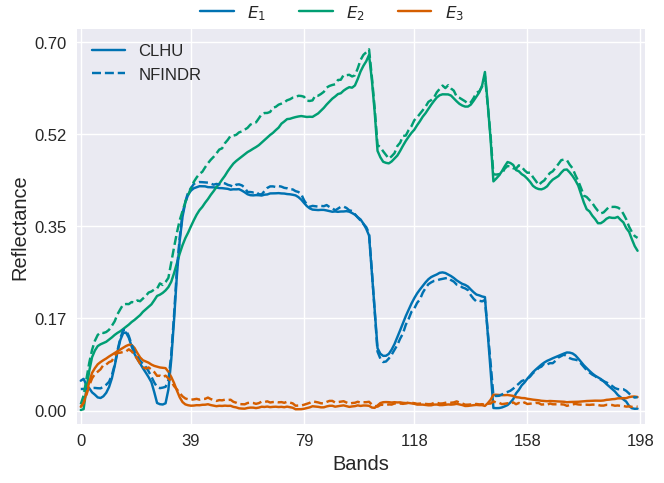

In [17]:
ebk = sigmoid(model.ebk).detach().cpu()

fig = plot_endmembers(ebk, ticks_range=(0, .7), endmember_estimation=[endmember_init], ee_labels=['CLHU','NFINDR'])
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/E_clhu_est.pdf'), bbox_inches='tight')

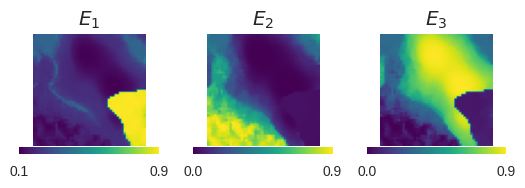

In [18]:
from torch.nn.functional import softmax
from utils import show_abundance

test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

fig = show_abundance(test)
plt.show(fig)

fig.savefig(os.path.join(result_path, 'imgs/A_clhu_est.png'), dpi=300, bbox_inches='tight')

In [38]:
xhat = model(_X).detach().cpu()

from HySpecLab.metrics import rmse, sad
rmse_x_clhu = rmse(xhat, _X, dim=None)
sad_m_clhu = np.diagonal(sad(ebk, dataset.endmembers())).mean()
print(sad_m_clhu)

print(r'$RMSE_X$ = {:.4f}'.format(rmse_x_clhu))
print(r'SAD')

0.09867701
$RMSE_X$ = 0.0134


# LMM and ELMM solution

In [31]:
result_path = os.path.join(config.RESULTS_PATH, 'syntheticData/data')

from dataset import SyntheticDataset
dataset = SyntheticDataset(config.Synthetic_PATH)

In [32]:
from scipy import io as sio
from HySpecLab.metrics import sad

endmember_estimation = sio.loadmat(os.path.join(result_path, 'endmember_estimation.mat'))
vca_ee = torch.tensor(endmember_estimation['VCA'])
nfindr_ee = torch.tensor(endmember_estimation['NFINDR'])

sad_result = sad(vca_ee, dataset.endmembers())
vca_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth

sad_result = sad(nfindr_ee, dataset.endmembers())
nfindr_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth

vca_ee = vca_ee[vca_idx]
nfindr_ee = nfindr_ee[nfindr_idx]

In [33]:
input = sio.loadmat(os.path.join(result_path, 'input.mat'))
X = torch.tensor(input['X'].reshape(-1, input['X'].shape[-1], order='F'))

## Endmember

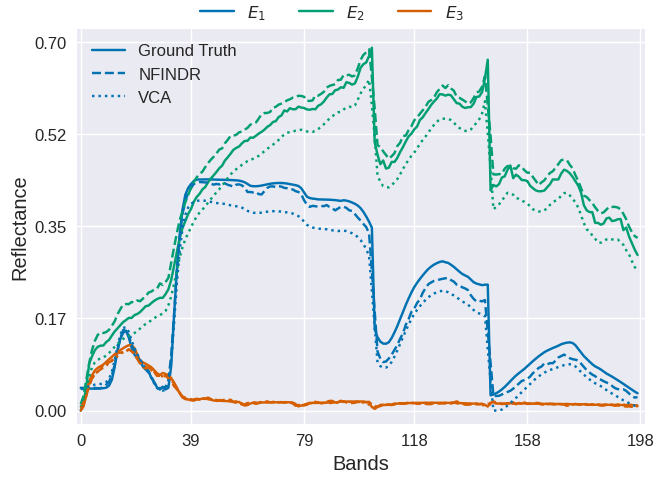

In [34]:
from utils import plot_endmembers
fig = plot_endmembers(dataset.endmembers(), ticks_range=(0, .7), 
                      endmember_estimation=[nfindr_ee, vca_ee],
                      ee_labels=['Ground Truth', 'NFINDR', 'VCA'])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/endmembers_estimation.pdf'), bbox_inches='tight')

In [35]:
from HySpecLab.metrics import sad

sad_result_vca = sad(vca_ee, dataset.endmembers())
print(sad_result_vca, np.diagonal(sad_result_vca.numpy()).mean())

sad_result_nfindr = sad(nfindr_ee, dataset.endmembers())
print(sad_result_nfindr, np.diagonal(sad_result_nfindr.numpy()).mean())


tensor([[0.0868, 0.5174, 1.1149],
        [0.4418, 0.0293, 1.1076],
        [1.1113, 1.0725, 0.0410]]) 0.05237831
tensor([[0.0651, 0.4921, 1.1298],
        [0.4404, 0.0349, 1.0778],
        [1.1119, 1.0733, 0.0591]]) 0.053007524


## LMM

In [ ]:
FCLS = sio.loadmat(os.path.join(result_path, 'FCLS.mat'))
save_dir = os.path.join(result_path, 'imgs/LMM')

Xhat = FCLS['Xhat_NFINDR'].T

from HySpecLab.metrics import rmse
nfindr_reconstruct = torch.tensor(FCLS['Xhat_NFINDR'].T)
vca_reconstruct = torch.tensor(FCLS['Xhat_VCA'].T)

# dataframe which contains the RMSE
# Saving metrics
import pandas as pd
lmm_df = pd.DataFrame(columns=['RMSE', 'Method', 'Endmember Estimation'])
lmm_df['RMSE'] = [rmse(X, nfindr_reconstruct, dim=None).numpy(), rmse(X, vca_reconstruct, dim=None).numpy()]
lmm_df['Method'] = ['LMM', 'LMM']
lmm_df['Endmember Estimation'] = ['NFINDR', 'VCA']
lmm_df

In [ ]:
from utils import show_abundance
A = FCLS['A_NFINDR'].T.reshape(50,50,-1,order='C')
fig = show_abundance(A[:, :, nfindr_idx])
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_NFINDR.png'), dpi=300, bbox_inches='tight')

A = FCLS['A_VCA'].T.reshape(50,50,-1,order='C')
fig = show_abundance(A[:, :, vca_idx])
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_VCA.png'), dpi=300, bbox_inches='tight')

## ELMM

In [ ]:
ELMM = sio.loadmat(os.path.join(result_path, 'ELMM.mat'))
save_dir = os.path.join(result_path, 'imgs/ELMM')

from HySpecLab.metrics import rmse
nfindr_reconstruct = torch.tensor(ELMM['Xhat_NFINDR'].T)
vca_reconstruct = torch.tensor(ELMM['Xhat_VCA'].T)

import pandas as pd
elmm_df = pd.DataFrame(columns=['RMSE', 'Method', 'Endmember Estimation'])
elmm_df['RMSE'] = [rmse(X, nfindr_reconstruct, dim=None).numpy(), rmse(X, vca_reconstruct, dim=None).numpy()]
elmm_df['Method'] = ['ELMM', 'ELMM']
elmm_df['Endmember Estimation'] = ['NFINDR', 'VCA']
elmm_df

In [ ]:
from utils import show_abundance
A = ELMM['A_NFINDR'].T.reshape(50,50,-1,order='C')
fig = show_abundance(A[:, :, nfindr_idx])
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_NFINDR.png'), dpi=300, bbox_inches='tight')

A = ELMM['A_VCA'].T.reshape(50,50,-1,order='C')
fig = show_abundance(A[:, :, vca_idx])
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_VCA.png'), dpi=300, bbox_inches='tight')

## Save Dataframe

In [ ]:
df = pd.concat([lmm_df, elmm_df])
# df.to_csv(os.path.join(result_path, 'metrics.csv'), index=False)
df